In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from astropy.table import Table
import corner

In [2]:
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis')
import statistics_ as sta
import mcmc as mcmc_

# Creating fake data assuming a model

We set the true parameters

In [3]:
free_p2 = False

In [4]:
p_1true, p_2true = 1, 1

We define the model

In [5]:
def model(x,p):
    
    p1, p2 = p
    
    return p1*x*np.cos(p2*x)

We create fake data described by the above model introducing fake noise

In [6]:
N = 20
noise = 0.05
x = np.linspace(0,1,N)
y_exp = model(x,[p_1true, p_2true]) + np.random.randn(N)*noise

We store the `x` data and `y` measured data in an `astropy` table

# Covariance Matrix

We create arbitrary covariance matrix

In [7]:
Stat = sta.Statistics(N)

In [8]:
for i in range(100):
    
    y_real = model(x,[p_1true, p_2true]) + np.random.randn(N)*noise
    
    Stat._add_realization(y_real)

In [9]:
Stat.estimate_covariance()
cov = Stat.covariance_matrix

<ErrorbarContainer object of 3 artists>

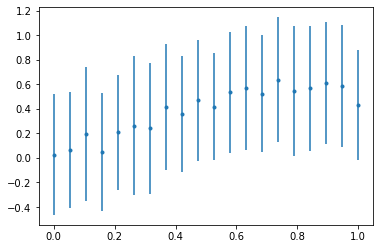

In [10]:
plt.errorbar(x,y_exp,np.sqrt(cov.diagonal()),fmt = '.')

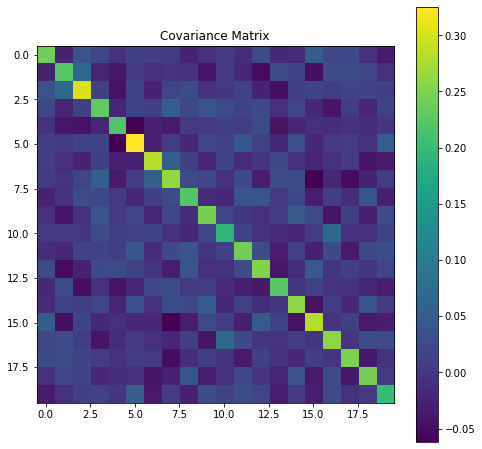

In [11]:
fig = plt.figure(figsize = (8,8))
plt.imshow(cov)
plt.title('Covariance Matrix')
plt.colorbar()
plt.show()

# Fit parameters using iMinuit

In [12]:
import iminuit
from iminuit import Minuit

In [13]:
def chi2(p):
    
    chi2=0
    
     # Calculated model at data x-values

    y_predict = np.array(model(x, p))

    delta = y_predict - y_exp

    inv_cov = np.linalg.inv(cov)

    chi2 =  np.sum(delta * inv_cov.dot(delta))
    
    return chi2

## Minimisation (we can fix some parameters, or define domains (see 

m = Minuit.from_array_func(chi2,
           (1,1), limit_p1 = (-2,4), limit_p2 = (-2, 4),
           errordef = 1,
        name=("p1", "p2"))
## Find minimum with Migrad
m.migrad()
## Run Hessian for uncertainties
m.hesse()
## Run Minos for more robust and asymetric error bars
m.minos()
## Calculate chi2_min/dof (I have two free parameters here)
chi2min_dof =  m.fval/(len(x)-2)
# retrieve best-fit values
# Print all (values, parameters, errors Hess and Minos)
print(m.params)

┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ p1   │    1.1    │    0.5    │    -0.5    │    0.5     │   -2    │    4    │       │
│ 1 │ p2   │   1.10    │   0.44    │   -0.44    │    0.31    │   -2    │    4    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


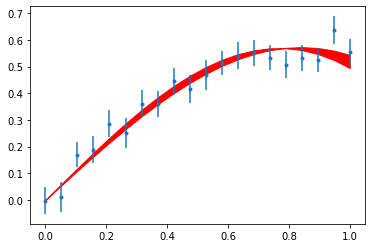

In [33]:
plt.errorbar(x,y_exp,np.sqrt(cov.diagonal()),fmt = '.')
y_up = model(x, [m.values['p1'] + m.merrors['p1'].upper, m.values['p2'] + m.merrors['p2'].upper])
y_down = model(x, [m.values['p1'] + m.merrors['p1'].lower, m.values['p2'] + m.merrors['p2'].lower])
plt.fill_between(x,y_up,y_down ,color = 'r', alpha = 1)
plt.show()